In [1]:
import os
import random
import argparse
from typing import Tuple

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

# ---------------------------
# Reproducibility & device
# ---------------------------
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# Model
# ---------------------------
class MLP(nn.Module):
    def __init__(self, in_dim: int, hidden=[64, 32], dropout=0.3):
        super().__init__()
        layers = []
        prev = in_dim
        for h in hidden:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, 1))  # single logit for BCEWithLogits
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(-1)  # [batch]

# ---------------------------
# Data helpers
# ---------------------------
def load_data(csv_path: str, target_col: str = "Outcome", test_size=0.2, val_size=0.1, random_state=42) -> Tuple:
    df = pd.read_csv(csv_path)
    assert target_col in df.columns, f"{target_col} not in CSV"
    X = df.drop(columns=[target_col]).values.astype(np.float32)
    y = df[target_col].values.astype(np.int64)

    X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=test_size+val_size,
                                                      random_state=random_state, stratify=y)
    rel_val = val_size / (test_size + val_size)
    X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=rel_val,
                                                    random_state=random_state, stratify=y_tmp)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    return (X_train, y_train), (X_val, y_val), (X_test, y_test), scaler

def make_loader(X, y, batch_size=32, shuffle=True):
    tX = torch.from_numpy(X)
    ty = torch.from_numpy(y).float()  # BCEWithLogits expects float targets
    ds = TensorDataset(tX, ty)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

# ---------------------------
# Train / Eval
# ---------------------------
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)
        logits = model(Xb)  # [batch]
        loss = criterion(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * Xb.size(0)
    return total_loss / len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    ys, preds, probs = [], [], []
    with torch.no_grad():
        for Xb, yb in loader:
            Xb = Xb.to(device)
            logits = model(Xb)
            p = torch.sigmoid(logits).cpu().numpy()
            pred = (p >= 0.5).astype(int)
            probs.extend(p.tolist())
            preds.extend(pred.tolist())
            ys.extend(yb.numpy().astype(int).tolist())
    acc = accuracy_score(ys, preds)
    try:
        auc = roc_auc_score(ys, probs)
    except Exception:
        auc = float("nan")
    return acc, auc

# ---------------------------
# Main
# ---------------------------
def main(args):
    set_seed(args.seed)
    (X_train, y_train), (X_val, y_val), (X_test, y_test), scaler = load_data(args.csv,
                target_col=args.target, test_size=args.test_size, val_size=args.val_size, random_state=args.seed)
    train_loader = make_loader(X_train, y_train, batch_size=args.batch_size, shuffle=True)
    val_loader = make_loader(X_val, y_val, batch_size=args.batch_size, shuffle=False)
    test_loader = make_loader(X_test, y_test, batch_size=args.batch_size, shuffle=False)

    model = MLP(in_dim=X_train.shape[1], hidden=[args.h1, args.h2], dropout=args.dropout).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

    best_val_auc = 0.0
    os.makedirs(args.save_dir, exist_ok=True)
    for epoch in range(1, args.epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
        val_acc, val_auc = evaluate(model, val_loader)
        print(f"[Epoch {epoch}] train_loss={train_loss:.4f} val_acc={val_acc:.4f} val_auc={val_auc:.4f}")

        if val_auc > best_val_auc:
            best_val_auc = val_auc
            ckpt = os.path.join(args.save_dir, "diabetes_mlp_best.pt")
            torch.save({"model_state": model.state_dict(), "scaler": scaler}, ckpt)
            print(f"  Saved best checkpoint to {ckpt}")

    test_acc, test_auc = evaluate(model, test_loader)
    print(f"Test acc={test_acc:.4f} auc={test_auc:.4f}")

In [2]:
if __name__ == "__main__":
    class Args:
        def __init__(self):
            self.csv = "diabetes.csv"
            self.target = "Outcome"
            self.epochs = 30
            self.batch_size = 32
            self.lr = 1e-3
            self.h1 = 64
            self.h2 = 32
            self.dropout = 0.3
            self.save_dir = "checkpoints"
            self.seed = 42
            self.test_size = 0.2
            self.val_size = 0.1

    args = Args()
    main(args)

[Epoch 1] train_loss=0.6563 val_acc=0.6494 val_auc=0.7900
  Saved best checkpoint to checkpoints/diabetes_mlp_best.pt
[Epoch 2] train_loss=0.6110 val_acc=0.6494 val_auc=0.8343
  Saved best checkpoint to checkpoints/diabetes_mlp_best.pt
[Epoch 3] train_loss=0.5813 val_acc=0.6688 val_auc=0.8339
[Epoch 4] train_loss=0.5434 val_acc=0.7338 val_auc=0.8350
  Saved best checkpoint to checkpoints/diabetes_mlp_best.pt
[Epoch 5] train_loss=0.5216 val_acc=0.7468 val_auc=0.8378
  Saved best checkpoint to checkpoints/diabetes_mlp_best.pt
[Epoch 6] train_loss=0.5090 val_acc=0.7338 val_auc=0.8313
[Epoch 7] train_loss=0.5016 val_acc=0.7403 val_auc=0.8269
[Epoch 8] train_loss=0.4930 val_acc=0.7078 val_auc=0.8309
[Epoch 9] train_loss=0.4720 val_acc=0.7273 val_auc=0.8317
[Epoch 10] train_loss=0.4716 val_acc=0.7273 val_auc=0.8333
[Epoch 11] train_loss=0.4529 val_acc=0.7338 val_auc=0.8330
[Epoch 12] train_loss=0.4741 val_acc=0.7273 val_auc=0.8352
[Epoch 13] train_loss=0.4675 val_acc=0.7208 val_auc=0.8348
[E

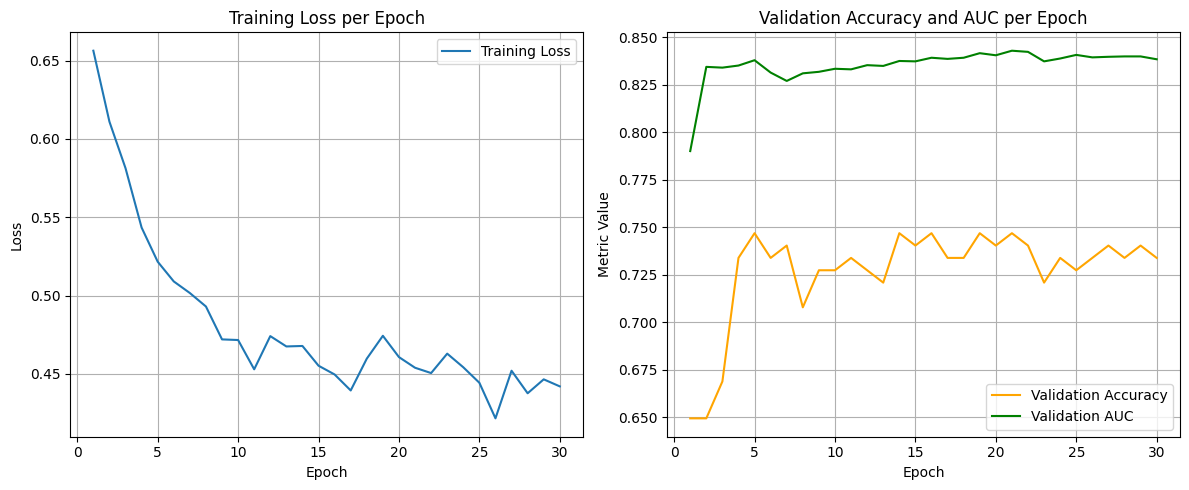

In [3]:
import matplotlib.pyplot as plt
import re

# Extract data from the output
output = """
[Epoch 1] train_loss=0.6563 val_acc=0.6494 val_auc=0.7900
  Saved best checkpoint to checkpoints/diabetes_mlp_best.pt
[Epoch 2] train_loss=0.6110 val_acc=0.6494 val_auc=0.8343
  Saved best checkpoint to checkpoints/diabetes_mlp_best.pt
[Epoch 3] train_loss=0.5813 val_acc=0.6688 val_auc=0.8339
[Epoch 4] train_loss=0.5434 val_acc=0.7338 val_auc=0.8350
  Saved best checkpoint to checkpoints/diabetes_mlp_best.pt
[Epoch 5] train_loss=0.5216 val_acc=0.7468 val_auc=0.8378
  Saved best checkpoint to checkpoints/diabetes_mlp_best.pt
[Epoch 6] train_loss=0.5090 val_acc=0.7338 val_auc=0.8313
[Epoch 7] train_loss=0.5016 val_acc=0.7403 val_auc=0.8269
[Epoch 8] train_loss=0.4930 val_acc=0.7078 val_auc=0.8309
[Epoch 9] train_loss=0.4720 val_acc=0.7273 val_auc=0.8317
[Epoch 10] train_loss=0.4716 val_acc=0.7273 val_auc=0.8333
[Epoch 11] train_loss=0.4529 val_acc=0.7338 val_auc=0.8330
[Epoch 12] train_loss=0.4741 val_acc=0.7273 val_auc=0.8352
[Epoch 13] train_loss=0.4675 val_acc=0.7208 val_auc=0.8348
[Epoch 14] train_loss=0.4678 val_acc=0.7468 val_auc=0.8374
[Epoch 15] train_loss=0.4552 val_acc=0.7403 val_auc=0.8372
[Epoch 16] train_loss=0.4496 val_acc=0.7468 val_auc=0.8391
  Saved best checkpoint to checkpoints/diabetes_mlp_best.pt
[Epoch 17] train_loss=0.4394 val_acc=0.7338 val_auc=0.8385
[Epoch 18] train_loss=0.4597 val_acc=0.7338 val_auc=0.8391
[Epoch 19] train_loss=0.4743 val_acc=0.7468 val_auc=0.8415
  Saved best checkpoint to checkpoints/diabetes_mlp_best.pt
[Epoch 20] train_loss=0.4607 val_acc=0.7403 val_auc=0.8404
[Epoch 21] train_loss=0.4539 val_acc=0.7468 val_auc=0.8428
  Saved best checkpoint to checkpoints/diabetes_mlp_best.pt
[Epoch 22] train_loss=0.4505 val_acc=0.7403 val_auc=0.8422
[Epoch 23] train_loss=0.4629 val_acc=0.7208 val_auc=0.8372
[Epoch 24] train_loss=0.4542 val_acc=0.7338 val_auc=0.8387
[Epoch 25] train_loss=0.4443 val_acc=0.7273 val_auc=0.8406
[Epoch 26] train_loss=0.4216 val_acc=0.7338 val_auc=0.8393
[Epoch 27] train_loss=0.4520 val_acc=0.7403 val_auc=0.8396
[Epoch 28] train_loss=0.4376 val_acc=0.7338 val_auc=0.8398
[Epoch 29] train_loss=0.4465 val_acc=0.7403 val_auc=0.8398
[Epoch 30] train_loss=0.4420 val_acc=0.7338 val_auc=0.8383
Test acc=0.7403 auc=0.8237
"""

epochs = []
train_losses = []
val_accs = []
val_aucs = []

for line in output.strip().split('\n'):
    if line.startswith('[Epoch'):
        match = re.search(r'\[Epoch (\d+)\] train_loss=([\d\.]+) val_acc=([\d\.]+) val_auc=([\d\.]+)', line)
        if match:
            epoch, train_loss, val_acc, val_auc = match.groups()
            epochs.append(int(epoch))
            train_losses.append(float(train_loss))
            val_accs.append(float(val_acc))
            val_aucs.append(float(val_auc))

# Plotting
plt.figure(figsize=(12, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy and AUC
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accs, label='Validation Accuracy', color='orange')
plt.plot(epochs, val_aucs, label='Validation AUC', color='green')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Validation Accuracy and AUC per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

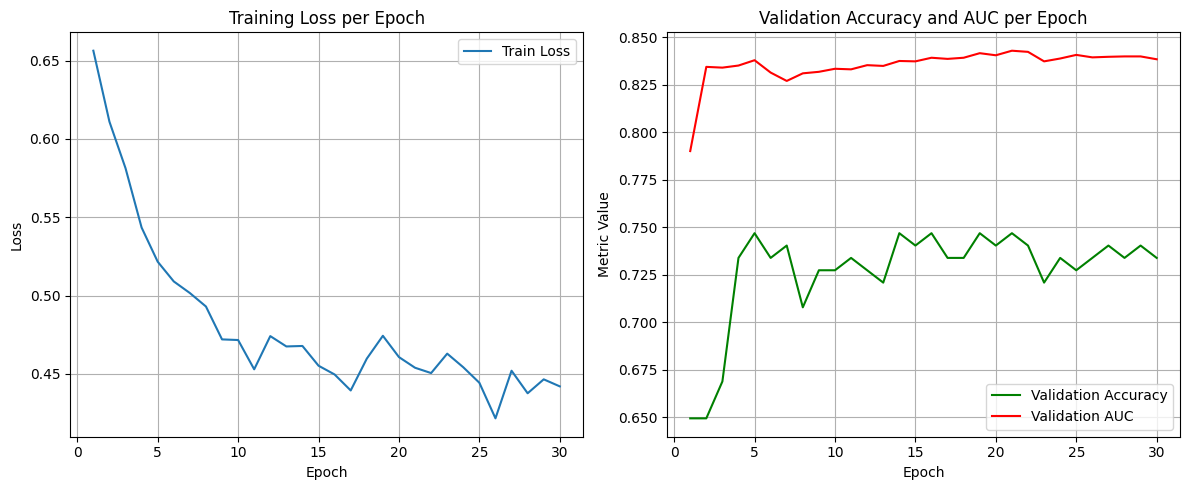